# Differential pair generator
```
Time Transcenders Team, July 2025
SPDX-License-Identifier: Apache-2.0
```

**PCell Generators**
1. Primitive Cells / `glayout.primitives`
  - FET (NMOS, PMOS)
  - MIM Capacitor
  - Guard Rings with Metalization
  - Via

In [348]:
import numpy as np
import os

In [331]:
from glayout import sky130, gf180, MappedPDK
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

from gdsfactory import Component
from gdsfactory.components import rectangle, text_freetype

from glayout import rename_ports_by_orientation

In [332]:
from glayout.primitives.via_gen import via_stack, via_array
from glayout.primitives.fet import nmos, pmos, multiplier
from glayout.primitives.guardring import tapring

In [333]:
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.comp_utils import move, movex, movey
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

In [334]:
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

In [335]:
# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

### 1. Primitives
#### MOSFET (nmos/pmos)

**Parameters:**
- **pdk:** Which PDK to use
- **width:** Width of one finger (um)
- **length:** Length of one finger (um). The default value is the minimum channel length available
- **fingers:** Number of fingers per transistor
- **multipliers:** Number of transistors in this cell
- **with_tie:** bool
- **with_dummy:** tuple of 2 bools
- **with_dnwell:** bool
- **with_substrate_tap:** bool
- **sd_route_topmet:** Expose the S/D connection on which metal layer
- **gate_route_topmet:** Expose the Gate connection on which metal layer
- **sd_route_left:** Choose which direction the S/D connection goes to
- **rmult:** Integer multipler of routing width
- **sd_rmult:** Same as above
- **gate_rmult:** Same as above
- **interfinger_rmult:** Same as above
- **tie_layers:** Run the body tie metal on which layer. This entry is a tuple with 2 elements
    - X metal
    - Y metal
- **substrate_tap_layers:** Run the substrate tie metal on which layer. This entry is a tuple with 2 elements
    - X metal
    - Y metal
- **dummy_routes:** Enable routing to the dummy transistors

Note that most of the parameters have a default value. The user usually doesn't need to populate all of them.

## Defining the arguments for each of the two transistors

![alt text](./diff_pair_img.png "Differential Pair topology")

In [336]:
# Simple solution: Swap drain and source port names
# This changes the semantic meaning without touching the physical layout

def swap_drain_source_ports(mosfet_component):
    """
    Swap all drain and source port names in a MOSFET component.
    This effectively makes the drain become the source and vice versa.
    
    Args:
        mosfet_component: The MOSFET component to modify
        
    Returns:
        Modified component with swapped drain/source port names
    """
    
    # Make sure component is unlocked for modification
    mosfet_component.unlock()
    
    # Get all ports
    all_ports = list(mosfet_component.ports.items())
    
    # Create mapping of old names to new names
    port_name_mapping = {}
    
    for port_name, port in all_ports:
        new_name = port_name
        
        # Swap drain -> source
        if "drain" in port_name.lower():
            new_name = port_name.replace("drain", "source").replace("DRAIN", "SOURCE")
        # Swap source -> drain  
        elif "source" in port_name.lower():
            new_name = port_name.replace("source", "drain").replace("SOURCE", "DRAIN")
        
        port_name_mapping[port_name] = new_name
    
    # Remove all old ports and add them back with new names
    # Store port information first
    port_info = {}
    for old_name, port in all_ports:
        port_info[old_name] = {
            'center': port.center,
            'width': port.width,
            'orientation': port.orientation,
            'layer': port.layer,
            'port_type': getattr(port, 'port_type', None)
        }
    
    # Clear existing ports
    mosfet_component.ports.clear()
    
    # Add ports back with new names
    for old_name, new_name in port_name_mapping.items():
        info = port_info[old_name]
        try:
            mosfet_component.add_port(
                name=new_name,
                center=info['center'],
                width=info['width'], 
                orientation=info['orientation'],
                layer=info['layer']
            )
        except Exception as e:
            print(f"Warning: Could not rename port {old_name} to {new_name}: {e}")
    
    return mosfet_component

In [337]:
M1_kwargs = {
    "with_tie": False,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met3",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 2,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": False
}

M2_kwargs = {
    "with_tie": False,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met3",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 2,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": False
}

In [338]:
diff_pair_config={
        "pdk": gf180, # pdk to use
        "placement" : "vertical", # the two fets can be placed either vertically or horizontally
        "width": (5,5), # width of the M1 and M2 respectively.
        "length": (None,None), # length of the M1 and M2 respectively. None refers to the min length in the pdk.
        "fingers": (5,5), # no. of fingers M1 and M2 fet respectively.
        "multipliers": (1,1), #no. of multipliers of the M1 and M2 fet respectively.
        "dummy_1": (True,True), # dummy pattern for M1 fet (left,right)
        "dummy_2": (True,True), # dummy pattern for M2 (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers 
        "tie_layers2": ("met2","met1"), #tapring metal layers 
        "sd_rmult":2, # thickness of the sd metal layer.
}

In [339]:
width=diff_pair_config["width"]
length=diff_pair_config["length"]
fingers=diff_pair_config["fingers"]
multipliers=diff_pair_config["multipliers"]

dummy_1=diff_pair_config["dummy_1"]
dummy_2=diff_pair_config["dummy_2"]
tie_layers1=diff_pair_config["tie_layers1"]
tie_layers2=diff_pair_config["tie_layers2"]
sd_rmult=diff_pair_config["sd_rmult"]

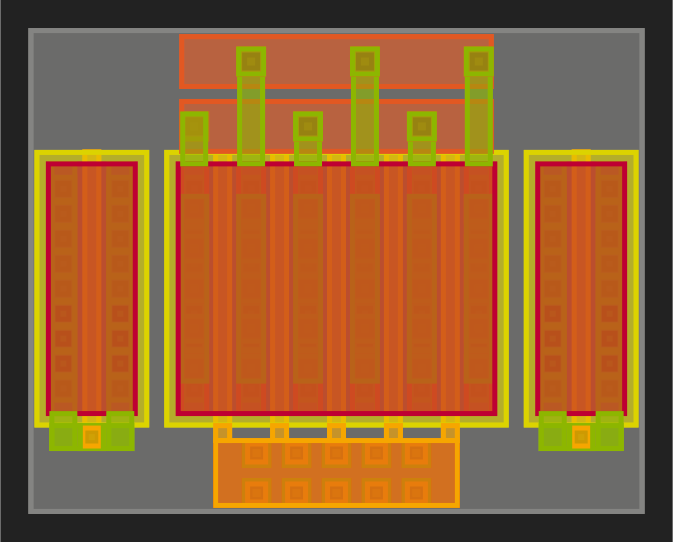

In [340]:
top_level = Component(name="differential_pair")
connect_source = True
pdk = diff_pair_config["pdk"]    

M1_temp = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **M1_kwargs)
M2_temp = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **M2_kwargs)

M1 = swap_drain_source_ports(M1_temp)
M2 = swap_drain_source_ports(M2_temp)

M1_ref = top_level << M1
M2_ref = top_level << M2

M1_ref.name="M1"
M2_ref.name="M2"

display_component(top_level, scale = 5)


### Placement

In [341]:
placement=diff_pair_config["placement"]
ref_dimensions = evaluate_bbox(M2)

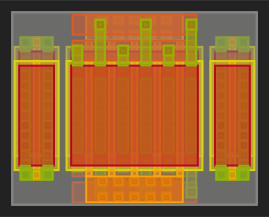

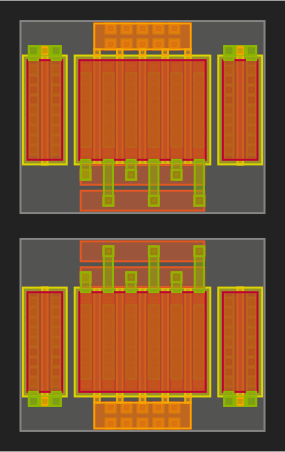

In [342]:
if placement == "horizontal":
    M1_ref.mirror_x()
    # Move M2 to the right, so it's leftmost edge touches the rightmost of M1
    M2_ref.movex(M1_ref.xmax + evaluate_bbox(M2)[0]/2 )
    display_component(top_level, scale = 2)
    # Add some more space between the fets, such that DRC is clean + 0.5um
    M2_ref.movex(pdk.util_max_metal_seperation()+0.5)
elif placement == "vertical":
    M1_ref.mirror_y()
    display_component(top_level, scale = 2)
    M2_ref.movey(M1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)
else:
        raise ValueError("Placement must be either 'horizontal' or 'vertical'.")
    
# let's see how our block looks after placement

display_component(top_level, scale = 2)

### Adding Tapring Around Differential Pair


Diff pair bounding box: (12.24, 20.56) 
 Diff pair center: [ 0.    -5.465]


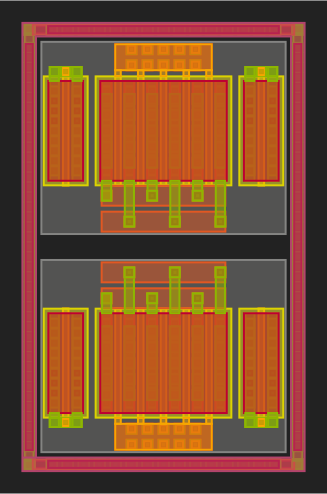

In [343]:
# Center the tapring around the differential pair
diff_pair_center = top_level.center
diff_pair_bbox = evaluate_bbox(top_level)

# Get the bounding box of the differential pair for tapring sizing
print(f"Diff pair bounding box: {diff_pair_bbox} \n Diff pair center: {diff_pair_center}")


# Create the tapring with appropriate parameters
# Using substrate tap for NMOS devices in bulk
tapring_comp = tapring(
    pdk=pdk,
    enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"])
)

# Add the tapring to our component
tapring_ref = top_level << tapring_comp
tapring_ref.name = "bulk_tapring_diff_pair"
tapring_ref.move(diff_pair_center)

display_component(top_level, scale = 2)


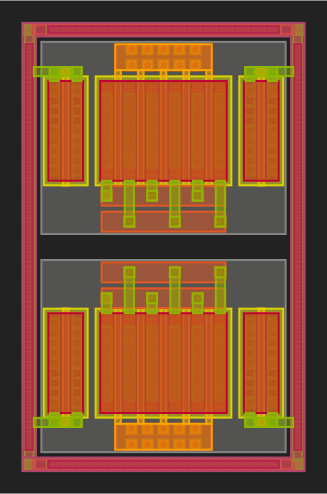

In [344]:
# Get connection points for all devices
device_gdscons = {
    'M1_L': M1_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"].center,
    'M1_R': M1_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"].center,
    'M2_L': M2_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"].center,
    'M2_R': M2_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"].center
}

# Get all tapring ports with "bottom_met" in name
tapring_ports = [port for port in tapring_ref.get_ports_list() if "bottom_met" in port.name.lower()]

def find_closest_port(target_pos, ports):
    """Find the closest port to a target position."""
    distances = [(np.linalg.norm(np.array(target_pos) - np.array(port.center)), port) 
                 for port in ports]
    return min(distances, key=lambda x: x[0])[1]

# Create routes for all connections
for device_name, gdscon_pos in device_gdscons.items():
    device_port_name = f"multiplier_0_dummy_{'L' if 'L' in device_name else 'R'}_gsdcon_bottom_met_{'E' if 'L' in device_name else 'W'}"
    device_ref = M1_ref if 'M1' in device_name else M2_ref
    
    closest_tapring_port = find_closest_port(gdscon_pos, tapring_ports)
    top_level << straight_route(pdk, device_ref.ports[device_port_name], tapring_ref.ports[closest_tapring_port.name])

display_component(top_level, scale=2)

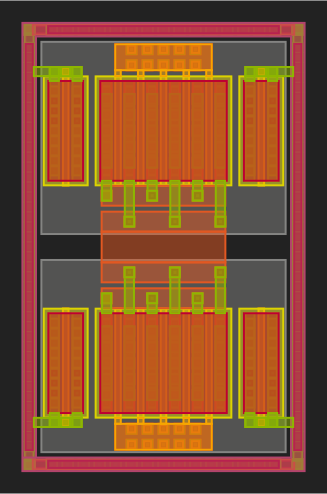

In [345]:
connected_sources = True
if connected_sources == True:
    # Connect the drains (sources) of the MOSFETS
    top_level << straight_route(pdk, M1_ref.ports["source_N"], M2_ref.ports["source_N"])

display_component(top_level, scale=2)

### Port labels

In [346]:
def add_transistor_pins(
    top_level: Component,
    M1_ref: Component,
    M2_ref: Component,
    pdk: MappedPDK,
    connected_sources: bool = False,
) -> Component:
    
    top_level.unlock()
    
    # Pin rectangle size
    psize = (0.5, 0.5)
    
    # List that will contain all port/component info
    move_info = list()
    
    # Get dynamic layers from the actual port layers
    def get_pin_layers(port_layer):
        """Convert port layer to corresponding pin and label layers"""
        # Get all available metal layers from PDK to find which one matches
        metal_layers = {
            pdk.get_glayer("met1"): ("met1_pin", "met1_label"),
            pdk.get_glayer("met2"): ("met2_pin", "met2_label"), 
            pdk.get_glayer("met3"): ("met3_pin", "met3_label"),
            pdk.get_glayer("met4"): ("met4_pin", "met4_label"),
            pdk.get_glayer("met5"): ("met5_pin", "met5_label"),
        }
        
        # Find matching metal layer
        for metal_layer, (pin_name, label_name) in metal_layers.items():
            if port_layer == metal_layer:
                try:
                    return pdk.get_glayer(pin_name), pdk.get_glayer(label_name)
                except:
                    # If pin/label layers don't exist, use the metal layer itself
                    return port_layer, port_layer
        
        # Default fallback - use the port layer itself
        return port_layer, port_layer
    
    # M1 Gate pin - dynamic layer from port
    m1_gate_port = M1_ref.ports["multiplier_0_gate_E"]
    m1_gate_pin_layer, m1_gate_label_layer = get_pin_layers(m1_gate_port.layer)
    m1_gate_label = rectangle(layer=m1_gate_pin_layer, size=psize, centered=True).copy()
    m1_gate_label.add_label(text="M1_GATE", layer=m1_gate_label_layer)
    move_info.append((m1_gate_label, m1_gate_port, None))
    
    # M1 Source pin - dynamic layer from port
    m1_source_port = M1_ref.ports["multiplier_0_source_E"]
    m1_source_pin_layer, m1_source_label_layer = get_pin_layers(m1_source_port.layer)
    m1_source_label = rectangle(layer=m1_source_pin_layer, size=psize, centered=True).copy()
    m1_source_label.add_label(text="M1_SOURCE", layer=m1_source_label_layer)
    move_info.append((m1_source_label, m1_source_port, None))
    
    # Check if drains should be connected and name accordingly
    if connected_sources:
        # If drains are connected, give them the same name
        drain_name = "DRAIN_COMMON"
        # Connect the drains with a route
        top_level << straight_route(pdk, M1_ref.ports["multiplier_0_drain_W"], M2_ref.ports["multiplier_0_drain_W"])
    else:
        # If drains are separate, give them different names
        drain_name = None  # Will be set individually below
    
    # M1 Drain pin - dynamic layer from port
    m1_drain_port = M1_ref.ports["multiplier_0_drain_W"]
    m1_drain_pin_layer, m1_drain_label_layer = get_pin_layers(m1_drain_port.layer)
    m1_drain_name = drain_name if drain_name else "M1_DRAIN"
    m1_drain_label = rectangle(layer=m1_drain_pin_layer, size=psize, centered=True).copy()
    m1_drain_label.add_label(text=m1_drain_name, layer=m1_drain_label_layer)
    move_info.append((m1_drain_label, m1_drain_port, None))
    
    # M2 Gate pin - dynamic layer from port
    m2_gate_port = M2_ref.ports["multiplier_0_gate_E"]
    m2_gate_pin_layer, m2_gate_label_layer = get_pin_layers(m2_gate_port.layer)
    m2_gate_label = rectangle(layer=m2_gate_pin_layer, size=psize, centered=True).copy()
    m2_gate_label.add_label(text="M2_GATE", layer=m2_gate_label_layer)
    move_info.append((m2_gate_label, m2_gate_port, None))
    
    # M2 Source pin - dynamic layer from port
    m2_source_port = M2_ref.ports["multiplier_0_source_E"]
    m2_source_pin_layer, m2_source_label_layer = get_pin_layers(m2_source_port.layer)
    m2_source_label = rectangle(layer=m2_source_pin_layer, size=psize, centered=True).copy()
    m2_source_label.add_label(text="M2_SOURCE", layer=m2_source_label_layer)
    move_info.append((m2_source_label, m2_source_port, None))
    
    # M2 Drain pin - dynamic layer from port
    m2_drain_port = M2_ref.ports["multiplier_0_drain_W"]
    m2_drain_pin_layer, m2_drain_label_layer = get_pin_layers(m2_drain_port.layer)
    m2_drain_name = drain_name if drain_name else "M2_DRAIN"
    m2_drain_label = rectangle(layer=m2_drain_pin_layer, size=psize, centered=True).copy()
    m2_drain_label.add_label(text=m2_drain_name, layer=m2_drain_label_layer)
    move_info.append((m2_drain_label, m2_drain_port, None))
    
    # Add all pin rectangles and labels to the component
    for comp, prt, alignment in move_info:
        alignment = ('c', 'b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)
    
    # Also add electrical ports for connectivity with appropriate naming
    top_level.add_port(port=M1_ref.ports["multiplier_0_gate_E"], name="M1_GATE")
    top_level.add_port(port=M2_ref.ports["multiplier_0_gate_E"], name="M2_GATE")
    top_level.add_port(port=M1_ref.ports["multiplier_0_source_E"], name="M1_SOURCE")
    top_level.add_port(port=M2_ref.ports["multiplier_0_source_E"], name="M2_SOURCE")
    
    # Add drain ports with conditional naming
    if connected_sources:
        # If connected, only add one common drain port (use M1's position as reference)
        top_level.add_port(port=M1_ref.ports["multiplier_0_drain_W"], name="DRAIN_COMMON")
    else:
        # If separate, add both individual drain ports
        top_level.add_port(port=M1_ref.ports["multiplier_0_drain_W"], name="M1_DRAIN")
        top_level.add_port(port=M2_ref.ports["multiplier_0_drain_W"], name="M2_DRAIN")
    
    return top_level.flatten()

# Usage examples:
# For separate sources:
#top_level_with_pins = add_transistor_pins(top_level, M1_ref, M2_ref, pdk, connected_sources=False)
# For connected drains:
top_level_with_pins = add_transistor_pins(top_level, M1_ref, M2_ref, gf180, connected_sources=True)
display_component(top_level_with_pins, scale=2)

NameError: name 'connect_drains' is not defined

In [351]:
diff_pair_code_string = """
from glayout import MappedPDK, sky130 , gf180
from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle

from glayout import nmos, pmos, multiplier
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring

from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.comp_utils import move, movex, movey
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist


from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route


import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

# Swap drain-source ports, to ease connections

def swap_drain_source_ports(mosfet_component):
    \"""
    Swap all drain and source port names in a MOSFET component.
    This effectively makes the drain become the source and vice versa.
    
    Args:
        mosfet_component: The MOSFET component to modify
        
    Returns:
        Modified component with swapped drain/source port names
    \"""
    
    # Make sure component is unlocked for modification
    mosfet_component.unlock()
    
    # Get all ports
    all_ports = list(mosfet_component.ports.items())
    
    # Create mapping of old names to new names
    port_name_mapping = {}
    
    for port_name, port in all_ports:
        new_name = port_name
        
        # Swap drain -> source
        if "drain" in port_name.lower():
            new_name = port_name.replace("drain", "source").replace("DRAIN", "SOURCE")
        # Swap source -> drain  
        elif "source" in port_name.lower():
            new_name = port_name.replace("source", "drain").replace("SOURCE", "DRAIN")
        
        port_name_mapping[port_name] = new_name
    
    # Remove all old ports and add them back with new names
    # Store port information first
    port_info = {}
    for old_name, port in all_ports:
        port_info[old_name] = {
            'center': port.center,
            'width': port.width,
            'orientation': port.orientation,
            'layer': port.layer,
            'port_type': getattr(port, 'port_type', None)
        }
    
    # Clear existing ports
    mosfet_component.ports.clear()
    
    # Add ports back with new names
    for old_name, new_name in port_name_mapping.items():
        info = port_info[old_name]
        try:
            mosfet_component.add_port(
                name=new_name,
                center=info['center'],
                width=info['width'], 
                orientation=info['orientation'],
                layer=info['layer']
            )
        except Exception as e:
            print(f"Warning: Could not rename port {old_name} to {new_name}: {e}")
    
    return mosfet_component

# Get dynamic layers from the actual port layers
def get_pin_layers(port_layer):
    # Convert port layer to corresponding pin and label layers
    # Get all available metal layers from PDK to find which one matches
    metal_layers = {
        pdk.get_glayer("met1"): ("met1_pin", "met1_label"),
        pdk.get_glayer("met2"): ("met2_pin", "met2_label"), 
        pdk.get_glayer("met3"): ("met3_pin", "met3_label"),
        pdk.get_glayer("met4"): ("met4_pin", "met4_label"),
        pdk.get_glayer("met5"): ("met5_pin", "met5_label"),
    }
    
    # Find matching metal layer
    for metal_layer, (pin_name, label_name) in metal_layers.items():
        if port_layer == metal_layer:
            try:
                return pdk.get_glayer(pin_name), pdk.get_glayer(label_name)
            except:
                # If pin/label layers don't exist, use the metal layer itself
                return port_layer, port_layer
    
    # Default fallback - use the port layer itself
    return port_layer, port_layer

def diff_pair_pins(
    top_level: Component,
    M1_ref: Component,
    M2_ref: Component,
    pdk: MappedPDK,
    connected_sources: bool,
) -> Component:

    top_level.unlock()
    
    # Pin rectangle size
    psize = (0.5, 0.5)
    
    # List that will contain all port/component info
    move_info = list()
        
    # M1 Gate pin - dynamic layer from port
    m1_gate_port = M1_ref.ports["multiplier_0_gate_E"]
    m1_gate_pin_layer, m1_gate_label_layer = get_pin_layers(m1_gate_port.layer)
    m1_gate_label = rectangle(layer=m1_gate_pin_layer, size=psize, centered=True).copy()
    m1_gate_label.add_label(text="M1_GATE", layer=m1_gate_label_layer)
    move_info.append((m1_gate_label, m1_gate_port, None))
    
    # M1 Source pin - dynamic layer from port
    m1_source_port = M1_ref.ports["multiplier_0_source_E"]
    m1_source_pin_layer, m1_source_label_layer = get_pin_layers(m1_source_port.layer)
    m1_source_label = rectangle(layer=m1_source_pin_layer, size=psize, centered=True).copy()
    m1_source_label.add_label(text="M1_SOURCE", layer=m1_source_label_layer)
    move_info.append((m1_source_label, m1_source_port, None))
    
    # Check if sources should be connected and named accordingly
    if connected_sources:
        # If drains are connected, give them the same name
        drain_name = "DRAIN_COMMON"
        # Connect the drains with a route
        top_level << straight_route(pdk, M1_ref.ports["multiplier_0_drain_W"], M2_ref.ports["multiplier_0_drain_W"])
    else:
        # If drains are separate, give them different names
        drain_name = None  # Will be set individually below
    
    # M1 Drain pin - dynamic layer from port
    m1_drain_port = M1_ref.ports["multiplier_0_drain_W"]
    m1_drain_pin_layer, m1_drain_label_layer = get_pin_layers(m1_drain_port.layer)
    m1_drain_name = drain_name if drain_name else "M1_DRAIN"
    m1_drain_label = rectangle(layer=m1_drain_pin_layer, size=psize, centered=True).copy()
    m1_drain_label.add_label(text=m1_drain_name, layer=m1_drain_label_layer)
    move_info.append((m1_drain_label, m1_drain_port, None))
    
    # M2 Gate pin - dynamic layer from port
    m2_gate_port = M2_ref.ports["multiplier_0_gate_E"]
    m2_gate_pin_layer, m2_gate_label_layer = get_pin_layers(m2_gate_port.layer)
    m2_gate_label = rectangle(layer=m2_gate_pin_layer, size=psize, centered=True).copy()
    m2_gate_label.add_label(text="M2_GATE", layer=m2_gate_label_layer)
    move_info.append((m2_gate_label, m2_gate_port, None))
    
    # M2 Source pin - dynamic layer from port
    m2_source_port = M2_ref.ports["multiplier_0_source_E"]
    m2_source_pin_layer, m2_source_label_layer = get_pin_layers(m2_source_port.layer)
    m2_source_label = rectangle(layer=m2_source_pin_layer, size=psize, centered=True).copy()
    m2_source_label.add_label(text="M2_SOURCE", layer=m2_source_label_layer)
    move_info.append((m2_source_label, m2_source_port, None))
    
    # M2 Drain pin - dynamic layer from port
    m2_drain_port = M2_ref.ports["multiplier_0_drain_W"]
    m2_drain_pin_layer, m2_drain_label_layer = get_pin_layers(m2_drain_port.layer)
    m2_drain_name = drain_name if drain_name else "M2_DRAIN"
    m2_drain_label = rectangle(layer=m2_drain_pin_layer, size=psize, centered=True).copy()
    m2_drain_label.add_label(text=m2_drain_name, layer=m2_drain_label_layer)
    move_info.append((m2_drain_label, m2_drain_port, None))
    
    # Add all pin rectangles and labels to the component
    for comp, prt, alignment in move_info:
        alignment = ('c', 'b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)
    
    # Also add electrical ports for connectivity with appropriate naming
    top_level.add_port(port=M1_ref.ports["multiplier_0_gate_E"], name="M1_GATE")
    top_level.add_port(port=M2_ref.ports["multiplier_0_gate_E"], name="M2_GATE")
    top_level.add_portdiff_pair_pins(port=M1_ref.ports["multiplier_0_source_E"], name="M1_DRAIN")
    top_level.add_port(port=M2_ref.ports["multiplier_0_source_E"], name="M2_DRAIN")
    
    # Add drain ports with conditional naming
    if connected_sources:
        # If connected, only add one common drain port (use M1's position as reference)
        top_level.add_port(port=M1_ref.ports["multiplier_0_drain_W"], name="SOURCE_COMMON")
    else:
        # If separate, add both individual drain ports
        top_level.add_port(port=M1_ref.ports["multiplier_0_drain_W"], name="M1_SOURCE")
        top_level.add_port(port=M2_ref.ports["multiplier_0_drain_W"], name="M2_SOURCE")
    
    return top_level.flatten()

    
@cell
def diff_pair(
        pdk: MappedPDK,
        placement: str = "vertical",
        width: tuple[float,float] = (3,3),
        length: tuple[float,float] = (None,None),
        fingers: tuple[int,int] = (1,1),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        connected_sources: bool = True,
        **kwargs        
        ) -> Component:

    pdk.activate()
    
    ##top level component
    top_level = Component(name="diff_pair")

    ## two fets
    ## temp mosfets, so we can switch the drain/source ports
    M1_temp = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **M1_kwargs)
    M2_temp = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **M2_kwargs)
    
    M1 = swap_drain_source_ports(M1_temp)
    M2 = swap_drain_source_ports(M2_temp)
    
    M1_ref = top_level << M1
    M2_ref = top_level << M2
    
    M1_ref.name="M1"
    M2_ref.name="M2"
    
    if placement == "horizontal":
        M1_ref.mirror_x()
        M2_ref.movex(M1_ref.xmax + evaluate_bbox(M2)[0]/2 )
        M2_ref.movex(pdk.util_max_metal_seperation()+0.5)
    elif placement == "vertical":
        M1_ref.mirror_y()
        M2_ref.movey(M1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)
    else:
            raise ValueError("Placement must be either 'horizontal' or 'vertical'.")

    ## connect up the drains/sources of the MOSFETS if connect_sources is set to True
    if connected_sources == True:
        if placement == "vertical" :
            top_level << straight_route(pdk, M1_ref.ports["drain_N"], M2_ref.ports["drain_N"])

    
    # Tapring surrounding the two transistors
    
    ## Center the tapring around the differential pair
    diff_pair_center = top_level.center
    diff_pair_bbox = evaluate_bbox(top_level)
    
    ## Get the bounding box of the differential pair for tapring sizing
    print(f"Diff pair bounding box: {diff_pair_bbox} \n Diff pair center: {diff_pair_center}")
    
    
    ## Create the tapring with appropriate parameters
    ## Using substrate tap for NMOS devices in bulk
    tapring_comp = tapring(
        pdk=pdk,
        enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"])
    )
    
    ## Add the tapring to our component
    tapring_ref = top_level << tapring_comp
    tapring_ref.name = "bulk_tapring_diff_pair"
    tapring_ref.move(diff_pair_center)

    ## connect up the dummy transistors to the tapring
    ## Get connection points for all devices
    device_gdscons = {
        'M1_L': M1_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"].center,
        'M1_R': M1_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"].center,
        'M2_L': M2_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"].center,
        'M2_R': M2_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"].center
    }
    
    ## Get all tapring ports with "bottom_met" in name
    tapring_ports = [port for port in tapring_ref.get_ports_list() if "bottom_met" in port.name.lower()]
    
    def find_closest_port(target_pos, ports):
        #Find the closest port to a target position.
        distances = [(np.linalg.norm(np.array(target_pos) - np.array(port.center)), port) 
                     for port in ports]
        return min(distances, key=lambda x: x[0])[1]
    
    ## Create routes for all connections
    for device_name, gdscon_pos in device_gdscons.items():
        device_port_name = f"multiplier_0_dummy_{'L' if 'L' in device_name else 'R'}_gsdcon_bottom_met_{'E' if 'L' in device_name else 'W'}"
        device_ref = M1_ref if 'M1' in device_name else M2_ref
        
        closest_tapring_port = find_closest_port(gdscon_pos, tapring_ports)
        top_level << straight_route(pdk, device_ref.ports[device_port_name], tapring_ref.ports[closest_tapring_port.name])


    #Routing
    top_level_with_pins = diff_pair_pins(top_level, M1_ref, M2_ref, gf180, connected_sources)
    
    return component_snap_to_grid(rename_ports_by_orientation(top_level_with_pins))


if __name__ == "__main__":
\tcomp = diff_pair(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_inv_labels(comp, gf180)\n
\tcomp.name = "DIFF_PAIR"\n
\tcomp.write_gds('out_diff_pair.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "DIFF_PAIR")\n
\tdrc_result = gf180.drc(comp)\n
"""

diff_pair_init_string = """
###Glayout Differential Pair Cell.


from .diff_pair import diff_pair

__all__ = [
    'diff_pair',
] 
"""

directory = "../../python/diff_pair"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "/diff_pair.py", "w") as file:
    file.write(diff_pair_code_string)

with open(directory + "/__init__.py", "w") as file:
    file.write(diff_pair_init_string)

